<a href="https://colab.research.google.com/github/romanzelararg/GRUPO-11---Proyecto-Final-Cohorte-2022-/blob/main/ISPC_Piletas_Entrenamiento_act.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detección de piletas utilizando imágenes satelitales y deep learning.
## ENTRENAMIENTO

El procesamiento de imágenes, combinado con la el machine learning, ofrece un gran potencial para la ciencia de datos. Un ejemplo de aplicación y uso para la Gestion Urbana es la detección de piletas.

Mediante el framework Raster Vision se propone realizar el procedimiento completo de aprendizaje profundo geoespacial: leer datos georreferenciados, entrenar modelos, realizar predicciones y escribir predicciones en formatos georreferenciados.


#### Se propone desarrollar un sistema automatizado que use:
- Imágenes satelitales de alta resolución para identificar posibles piletas.
- Algoritmos de aprendizaje profundo, entrenados para reconocer formas y reflejos de agua en las imágenes.

#### Este sistema podría implementarse por entidades recaudadoras para:
- Reducir la evasión fiscal
- Aumentar la equidad tributaria
- Optimizar recursos en la fiscalización


##### Integrantes
- Romina Yael Hanun
- Federico Juchniewicz
- Samuel Kanneman
- Carla Lucero
- Leonardo Matías Mansilla
- Román Zelarayán






### Se configura el espacio de trabajo, clona el repositorio del framework, se conecta don DRIVE y se instalan las librerias

In [ ]:
# Se clona el repositorio 'raster-vision' de GitHub
%%sh
rm -rf raster-vision/
git clone https://github.com/azavea/raster-vision.git


Cloning into 'raster-vision'...


In [ ]:
# Se instalan las librerias

!pip install raster-vision/rastervision_pipeline/
!pip install raster-vision/rastervision_core/
!pip install raster-vision/rastervision_pytorch_learner/
!pip install raster-vision/rastervision_aws_s3/
!pip install raster-vision/rastervision_pytorch_backend/
!pip install rastervision
!pip install gdown

Processing ./raster-vision/rastervision_pipeline
  Preparing metadata (setup.py) ... done
  Created wheel for rastervision-pipeline: filename=rastervision_pipeline-0.30.2.dev0-py3-none-any.whl size=71788 sha256=2fbfd65d9f9aa698f79d8ad441f43dd14e04a0fadca848a06e094d0cc1de76f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-vvfgumbr/wheels/a2/b0/40/6e81e96fd508b92025df1bc01df0429c6c12379fa7c7c3306e
Successfully built rastervision-pipeline
  Attempting uninstall: rastervision-pipeline
    Found existing installation: rastervision-pipeline 0.30.2.dev0
    Uninstalling rastervision-pipeline-0.30.2.dev0:
      Successfully uninstalled rastervision-pipeline-0.30.2.dev0
Processing ./raster-vision/rastervision_core
  Preparing metadata (setup.py) ... done
  Created wheel for rastervision-core: filename=rastervision_core-0.30.2.dev0-py3-none-any.whl size=345354 sha256=20ed117cd8c58eeb11b7ea49cfdde78de97001dcdcb70eb7ca841252d1f7e026
  Stored in directory: /tmp/pip-ephem-wheel-cache-q5dkvbd8/whe

In [ ]:
# Se configuran los permisos necesarios en Colab (LINUX)


!sudo apt-get install gdal-bin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# Se conecta a google

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Se importan las liberias

import fileinput

file_path = '/usr/local/lib/python3.10/dist-packages/rastervision/core/data/raster_source/multi_raster_source.py'
with fileinput.FileInput(file_path, inplace=True) as file:
    for line in file:
        print(line.replace('Self', 'Optional'), end='')
from rastervision.core.data import RasterioSource, MinMaxTransformer



import os
from subprocess import check_output

# Establece la variable de entorno 'GDAL_DATA' para especificar la ubicación de los datos de GDAL.
# GDAL es una biblioteca para leer y escribir formatos de datos geoespaciales.
# 'check_output' ejecuta un comando en la shell y devuelve su salida.
os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

import glob

# Importa varias clases de Raster Vision para trabajar con datos vectoriales, transformadores y configuraciones de clases.
from rastervision.core.data import (
    ClassConfig, GeoJSONVectorSource, RasterioCRSTransformer,
    RasterizedSource, ClassInferenceTransformer)

# Importa la clase para fuentes de etiquetas de segmentación semántica.
from rastervision.core.data import SemanticSegmentationLabelSource

# Utilidades para trabajar con datos GeoJSON y geometrías.
from rastervision.core.data.utils.geojson import get_polygons_from_uris
from shapely.geometry import Polygon

# Importa clases de Raster Vision para conjuntos de datos, visualización y aprendizaje profundo con PyTorch.
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset, SemanticSegmentationSlidingWindowGeoDataset, SemanticSegmentationVisualizer)

import albumentations as A

import torch
from torch.utils.data import ConcatDataset

# Importa configuraciones y clases de aprendizaje para segmentación semántica con PyTorch.
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationLearner


# En resumen, este código configura el entorno para trabajar con datos geoespaciales, define las transformaciones necesarias para los datos ráster y vectoriales,
# y prepara el entrenamiento de un modelo de segmentación semántica utilizando PyTorch a través de Raster Vision.
# Además, se asegura de que los datos necesarios de GDAL estén disponibles y permite el acceso a los datos almacenados en AWS S3 sin necesidad de autenticación.


### Configuracion de Iputs

In [ ]:
# Se define la imagen satelital para el entrenamiento
image_file_dest = "/content/drive/MyDrive/Deteccion/anotaciones/img_SAS_wgs_r.tif"

In [ ]:
# Se definen la ruta de las anotaciones y se guarda en una carpeta especifica
# (esto es util en para el caso que uno desee utilizar imagenes directamente desde la nube)

import gdown

!mkdir -p /content/drive/MyDrive/Deteccion/anotaciones/

annotations_url = "https://drive.google.com/file/d/1V9N0xDJKApR_p3PlFZ-9xSvMWWh1Xv3o/view?usp=drive_link"
annotations_file_dest = "/content/drive/MyDrive/Deteccion/anotaciones/anotaciones_wgs_geoj_r2.geojson"

gdown.download(annotations_url, annotations_file_dest, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=1V9N0xDJKApR_p3PlFZ-9xSvMWWh1Xv3o
To: /content/drive/MyDrive/Deteccion/anotaciones/anotaciones_wgs_geoj_r2.geojson
100%|██████████| 75.6k/75.6k [00:00<00:00, 25.1MB/s]


'/content/drive/MyDrive/Deteccion/anotaciones/anotaciones_wgs_geoj_r2.geojson'

In [ ]:
# Se definen la ruta del area de interes

AoI_file_dest = "/content/drive/MyDrive/Deteccion/anotaciones/sector_geoj_wgs84_r2.geojson"


# área de interés, almacenado en Google Drive.
# El archivo en cuestión es un archivo .geojson, que es un formato de archivo abierto para representar datos geoespaciales simples.
# Los archivos GeoJSON contienen información geográfica, como puntos, líneas y polígonos, junto con otros datos en formato JSON.


'\nárea de interés, almacenado en Google Drive.\nEl archivo en cuestión es un archivo .geojson, que es un formato de archivo abierto para representar datos geoespaciales simples.\nLos archivos GeoJSON contienen información geográfica, como puntos, líneas y polígonos, junto con otros datos en formato JSON.\n'

### Definición para el entrenamiento y la validación

In [ ]:
# Esta sección define las clases que el modelo intentará identificar en las imágenes.
# clases - Piletas y background

class_config = ClassConfig(
    names=['background', 'pileta'],
    colors=['lightgray', 'darkred'],
    null_class='background')


# tamaño en píxeles de los recortes cuadrados
window_size = 250

# transformaciones a realizar a los recorte del dataset

data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RandomBrightness(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=int(window_size/6), max_width=int(window_size/6), max_holes=4)
])



# Este código configura las clases para la segmentación, define el tamaño de las ventanas de entrenamiento
# y establece una serie de transformaciones de aumento de datos para mejorar la robustez del modelo de aprendizaje automático.
# Las transformaciones de aumento de datos son técnicas comunes para aumentar artificialmente la diversidad de los datos de entrenamiento sin recopilar nuevos datos,
# lo que puede mejorar la capacidad del modelo para generalizar a nuevas imágenes.


'\nEn resumen, este código configura las clases para la segmentación, define el tamaño de las ventanas de entrenamiento\ny establece una serie de transformaciones de aumento de datos para mejorar la robustez del modelo de aprendizaje automático.\nLas transformaciones de aumento de datos son técnicas comunes para aumentar artificialmente la diversidad de los datos de entrenamiento sin recopilar nuevos datos,\nlo que puede mejorar la capacidad del modelo para generalizar a nuevas imágenes.\n'

In [ ]:
# Se definen el conjunto de datos para la validacion

val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    aoi_uri=AoI_file_dest,
    image_uri=image_file_dest,
    label_vector_uri=annotations_file_dest,
    label_vector_default_class_id=class_config.get_class_id('pileta'),
    image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
    size=window_size,
    stride=window_size,
    transform=A.Resize(window_size, window_size))


# En resumen, este código prepara un conjunto de datos de validación que se utilizará para evaluar la precisión de un modelo de segmentación semántica,
# asegurándose de que las imágenes de entrada y las etiquetas estén correctamente alineadas y transformadas para el proceso de validación.



'\nEn resumen, este código prepara un conjunto de datos de validación que se utilizará para evaluar la precisión de un modelo de segmentación semántica,\nasegurándose de que las imágenes de entrada y las etiquetas estén correctamente alineadas y transformadas para el proceso de validación.\n'

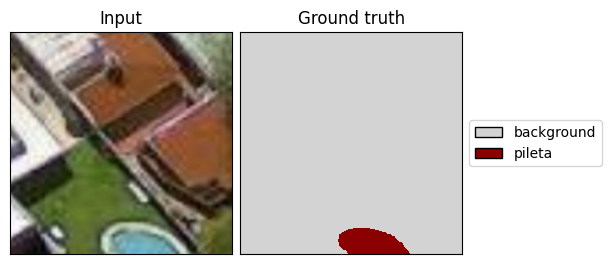

In [ ]:
# Se visualizan ejemplos de las ventanas de entrenamiento con las mascaras definidas

import random

def generar_numero_aleatorio():
    return random.randint(1, 200)


numero_aleatorio = generar_numero_aleatorio()


vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

x, y = val_ds[numero_aleatorio]

vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)


# Este código selecciona aleatoriamente un ejemplo del conjunto de datos de validación y utiliza SemanticSegmentationVisualizer
# para visualizar la imagen junto con su etiqueta de segmentación semántica.
# Esto es útil para verificar la calidad de las etiquetas o para inspeccionar los resultados de las predicciones del modelo.



In [ ]:
# Se obtiene el tamaño del conjunto de datos de validación para usarlo como referencia
# y Se crea un conjunto de datos de entrenamiento utilizando

sample_size = len(val_ds)

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    aoi_uri=AoI_file_dest,
    image_uri=image_file_dest,
    label_vector_uri=annotations_file_dest,
    label_vector_default_class_id=class_config.get_class_id('pileta'),
    image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
    # window sizes will randomly vary from 100x100 to 300x300
    #size_lims=(100, 300),
    # fixed window size
    size_lims=(window_size, window_size+1),
    # resize chips before returning
    out_size=window_size,
    # allow windows to overflow the extent by 100 pixels
    padding=100,
    max_windows=sample_size, # pero como estos datos son "pesados" vamos a limitarnos a tomar una muestra de la misma cantidad
    transform=data_augmentation_transform
)


# Este código prepara un conjunto de datos de entrenamiento con ventanas de imágenes y etiquetas correspondientes,
# listo para ser utilizado en el entrenamiento de un modelo de segmentación semántica.
# entanas se generan de manera aleatoria y se aplican transformaciones para aumentar la diversidad de los datos.


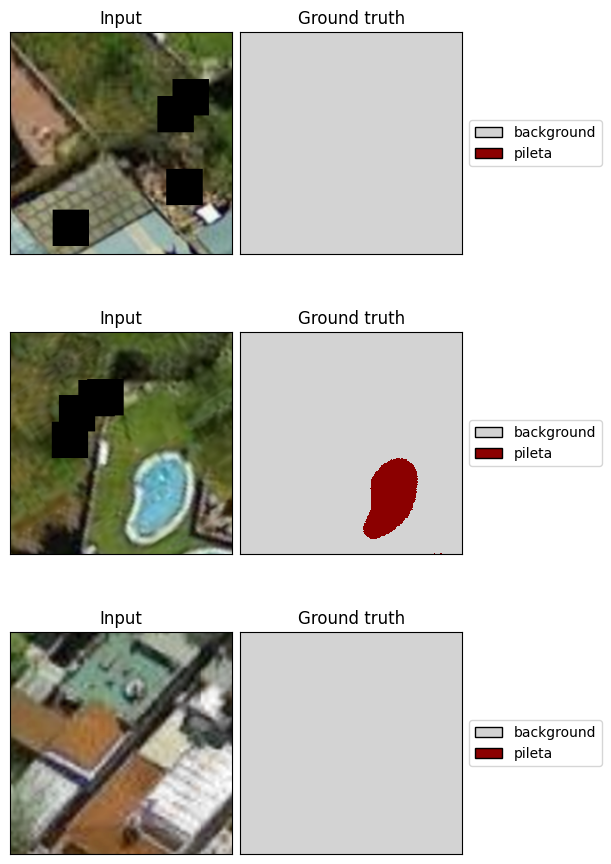

In [ ]:
# Se obtiene un lote de tres ejemplos (imágenes y etiquetas) del conjunto de datos de entrenamiento y se visualizan los mismos.

x, y = vis.get_batch(train_ds, 3)

vis.plot_batch(x, y, show=True)

In [ ]:
# Se carga un modelo preentrenado desde un repositorio de GitHub utilizando torch.hub.

import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(window_size, window_size),
    pretrained=True)


# En resumen, este código está preparando un modelo de segmentación panóptica basado en ResNet-18 y FPN para ser utilizado en tareas de visión por computadora,
# particularmente para la segmentación semántica de imágenes geoespaciales.
# El modelo está preentrenado, lo que significa que ya ha aprendido características útiles de un conjunto de datos grande y solo necesita ser afinado para la tarea específica.


Using cache found in /root/.cache/torch/hub/AdeelH_pytorch-fpn_0.3


In [ ]:
# Se define donde vamos a guardar el modelo entrenado
model_folder =  "/content/drive/MyDrive/Deteccion/"
# cantidad de iteraciones
n_epochs = 2

# cantidad de imagenes a cargar por iteración
# (limitada por la cantidad de memoria GPU y de memoria RAM)
# en los 15Gb RAM de la GPU de Google Colab entran tandas
# de hasta 60 imagenes de 480x480px

batch_images = 60
# Cuál es la configuración de clases a identidicar
data_cfg = SemanticSegmentationGeoDataConfig(
    class_config=class_config,
    num_workers=0, # increase to use multi-processing
)

In [ ]:
# Se define cuántas imágenes a cargar en memoria a la vez
solver_cfg = SolverConfig(
    batch_sz=batch_images,
    lr=0.01
)


In [ ]:
# Se combinan todas las opciones en un objeto "learner", que es el que realizará el entrenamiento


from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

In [ ]:
# Se crea una instancia de SemanticSegmentationLearner, que es una clase de Raster Vision
# diseñada para facilitar el entrenamiento de modelos de segmentación semántica

from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir=model_folder,
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
)


# Este fragmento de código está utilizando la biblioteca Raster Vision para configurar un aprendiz (learner) para la tarea de segmentación semántica,
# que es un tipo de modelo de aprendizaje profundo utilizado para clasificar cada píxel de una imagen en una categoría.


2024-06-06 22:07:20:rastervision.pytorch_learner.learner: INFO - Building dataloaders
INFO:rastervision.pytorch_learner.learner:Building dataloaders
2024-06-06 22:07:20:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from /content/drive/MyDrive/Deteccion/last-model.pth
INFO:rastervision.pytorch_learner.learner:Loading checkpoint from /content/drive/MyDrive/Deteccion/last-model.pth


In [ ]:
# Llama al método log_data_stats() del objeto learner.
learner.log_data_stats()


# learner.log_data_stats() es una herramienta de diagnóstico que proporciona una visión general de los datos con los que se está trabajando,
# asegurando que el proceso de entrenamiento se base en un fundamento sólido y bien informado.


2024-06-06 22:08:03:rastervision.pytorch_learner.learner: INFO - train_ds: 241 items
INFO:rastervision.pytorch_learner.learner:train_ds: 241 items
2024-06-06 22:08:03:rastervision.pytorch_learner.learner: INFO - valid_ds: 241 items
INFO:rastervision.pytorch_learner.learner:valid_ds: 241 items


### Ejecución del entrenamiento

In [ ]:
# Inicia el proceso de entrenamiento del modelo con un número específico de epochs.
learner.train(epochs=2)

# En resumen, learner.train(epochs=2) pone en marcha el entrenamiento del modelo durante dos épocas completas,
# permitiendo que el modelo aprenda de los datos y mejore su capacidad de hacer predicciones precisas sobre nuevas imágenes.

2024-06-06 22:08:34:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 4
INFO:rastervision.pytorch_learner.learner:Resuming training from epoch 4
2024-06-06 22:08:34:rastervision.pytorch_learner.learner: INFO - train_ds: 241 items
INFO:rastervision.pytorch_learner.learner:train_ds: 241 items
2024-06-06 22:08:34:rastervision.pytorch_learner.learner: INFO - valid_ds: 241 items
INFO:rastervision.pytorch_learner.learner:valid_ds: 241 items
2024-06-06 22:08:34:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
INFO:rastervision.pytorch_learner.learner:Plotting sample training batch.
2024-06-06 22:09:03:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
INFO:rastervision.pytorch_learner.learner:Plotting sample validation batch.
2024-06-06 22:09:36:rastervision.pytorch_learner.learner: INFO - epoch: 4
INFO:rastervision.pytorch_learner.learner:epoch: 4


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

2024-06-06 22:15:17:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 4,
 'train_loss': 0.05648573115468025,
 'train_time': '0:04:13.862795',
 'val_loss': 0.04225623235106468,
 'avg_precision': 0.9875122308731079,
 'avg_recall': 0.9937365055084229,
 'avg_f1': 0.9906145930290222,
 'background_precision': 0.9937365055084229,
 'background_recall': 1.0,
 'background_f1': 0.9968584179878235,
 'pileta_precision': 0.0,
 'pileta_recall': 0.0,
 'pileta_f1': 0.0,
 'valid_time': '0:01:26.946323'}
INFO:rastervision.pytorch_learner.learner:metrics:
{'epoch': 4,
 'train_loss': 0.05648573115468025,
 'train_time': '0:04:13.862795',
 'val_loss': 0.04225623235106468,
 'avg_precision': 0.9875122308731079,
 'avg_recall': 0.9937365055084229,
 'avg_f1': 0.9906145930290222,
 'background_precision': 0.9937365055084229,
 'background_recall': 1.0,
 'background_f1': 0.9968584179878235,
 'pileta_precision': 0.0,
 'pileta_recall': 0.0,
 'pileta_f1': 0.0,
 'valid_time': '0:01:26.946323'}
2024-06-06 22

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

2024-06-06 22:20:24:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 5,
 'train_loss': 0.06400160491466522,
 'train_time': '0:03:38.151374',
 'val_loss': 0.03816799074411392,
 'avg_precision': 0.9875122308731079,
 'avg_recall': 0.9937365055084229,
 'avg_f1': 0.9906145930290222,
 'background_precision': 0.9937365055084229,
 'background_recall': 1.0,
 'background_f1': 0.9968584179878235,
 'pileta_precision': 0.0,
 'pileta_recall': 0.0,
 'pileta_f1': 0.0,
 'valid_time': '0:01:28.498032'}
INFO:rastervision.pytorch_learner.learner:metrics:
{'epoch': 5,
 'train_loss': 0.06400160491466522,
 'train_time': '0:03:38.151374',
 'val_loss': 0.03816799074411392,
 'avg_precision': 0.9875122308731079,
 'avg_recall': 0.9937365055084229,
 'avg_f1': 0.9906145930290222,
 'background_precision': 0.9937365055084229,
 'background_recall': 1.0,
 'background_f1': 0.9968584179878235,
 'pileta_precision': 0.0,
 'pileta_recall': 0.0,
 'pileta_f1': 0.0,
 'valid_time': '0:01:28.498032'}


In [ ]:
# Guarda el modelo entrenado y la configuración asociada en un archivo.

learner.save_model_bundle()


# Este “paquete de modelo” es útil porque contiene todo lo necesario para cargar el modelo
# y utilizarlo para hacer predicciones en otro momento o en otro lugar sin tener que reconfigurar o reentrenar el modelo desde cero.


2024-06-06 22:21:12:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2024-06-06 22:21:12:rastervision.pytorch_learner.learner: INFO - Creating bundle.
INFO:rastervision.pytorch_learner.learner:Creating bundle.
2024-06-06 22:21:16:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.
INFO:rastervision.pytorch_learner.learner:Exporting to model to ONNX.
2024-06-06 22:21:36:rastervision.pytorch_learner.learner: INFO - Saving bundle to /content/drive/MyDrive/Deteccion/model-bundle.zip.
INFO:rastervision.pytorch_learner.learner:Saving bundle to /content/drive/MyDrive/Deteccion/model-bundle.zip.


Zipping: 0it [00:00, ?it/s, learner-config.json]